## Qrcodes classifier - Smallest CNN possible.

This is an exercise to study CNN, the goal was to make the smallest CNN possible for a simple, easy situation.
I could have used MNIST, but I wanted to do something different and even simpler.
I decided to set a really simple example: discriminate between a qrcode and its shuffled version. The main advantage is that qrcodes are tiny (37*37 pixels in this example), they can be generated easily and their patterns are so simple that a single convolution kernel should be enough to identify them with a good accuracy. The training time is short, making multiple tries unexpensive.

In [1]:
# Imports.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory as ds_from_dir

import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as img

### 1. Generation of the dataset.
First, generating the dataset with pyqrcode. We can play with the number of generated images.

In [2]:
def generate_qrcode_dataset(n_samples = 10, folder = 'default'):
    ''' This function will generate a dataset made of n_samples qrcodes 
    and n_samples shuffled qrcodes. They will be created in the folder/qrcodes
    and folder/noise folders, ready for Keras to open them.'''
    
    import pyqrcode
    import os
    import shutil
    from PIL import Image
    
    if folder == 'default':
        project_root = os.path.dirname(os.path.dirname(__file__))
    else:
        project_root = folder
        
    dataset_qrcodes = os.path.join(project_root, 'qrcodes')
    dataset_noise = os.path.join(project_root, 'noise')
    
    # If the folders exist, simply remove them and recreate everything
    try:
        os.makedirs(dataset_qrcodes)
        os.makedirs(dataset_noise)
        
    except:
        shutil.rmtree(project_root)
        os.makedirs(dataset_qrcodes)
        os.makedirs(dataset_noise)
           
    for i in range(n_samples):
        
        # The qrcodes will encode random numbers.
        # Length depends on the version and error parameter.
        to_encode = np.random.randint(10, size = 52)
        qrcode = pyqrcode.create(str(to_encode), error='L', version=5)
        
        array = np.array(qrcode.code).astype(np.uint8)
        array *= 255
        # Saving the qrcode as a .png
        im = Image.fromarray(array)
        im.save(dataset_qrcodes + '/' + str(i) + ".png")
        
        # Then shuffling it and saving it again in the "noise" folder.
        np.random.shuffle(array)
        im2 = Image.fromarray(array)
        im2.save(dataset_noise + '/' + str(i) + ".png")
               
        
    print('Qrcodes created in ' + dataset_qrcodes)
    print('Shuffled Qrcodes created in ' + dataset_noise)

In [3]:
# Where the pictures will be created, in /qrcodes and /noise folders.
dir_dataset = "D:/Python_Projects/qrcodeCNN/test"

In [4]:
# Decomment and use only once

# generate_qrcode_dataset(n_samples = 400, folder = dir_dataset)

### 2. Loading the dataset.

In [5]:
# Image_size is fixed by the qrcode version (here, 5)
image_size = (37, 37)
batch_size = 32

# Loading images automatically with image_dataset_from_directory
train_ds = ds_from_dir(dir_dataset, validation_split=0.2,
                       subset="training", seed=1337,
                       image_size=image_size, batch_size=batch_size,
                       color_mode="grayscale")

val_ds = ds_from_dir(dir_dataset, validation_split=0.2,
                     subset="validation", seed=1337,
                     image_size=image_size, batch_size=batch_size,
                     color_mode="grayscale")

Found 800 files belonging to 2 classes.
Using 640 files for training.
Found 800 files belonging to 2 classes.
Using 160 files for validation.


In [6]:
def show_examples(dataset):
    '''Simple functions to show 9 random examples (qrcode or noise) from the dataset.'''
    
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
            plt.title('qrcode' if int(labels[i]) == 1 else 'noise')
            
            plt.axis("off")

Examples of qrcodes and suffled versions. As we can see, it is pretty easy to make the difference. There is no rotation, shear, scale or anything fancy. By instinct, we can clearly see that the main difference lies in the presence or not of the square patterns in 3 corners of the qrcode. But that does not mean that the convolution kernel will select this pattern in particular. We can see that even in the shuffled versions, there are repeating patterns.

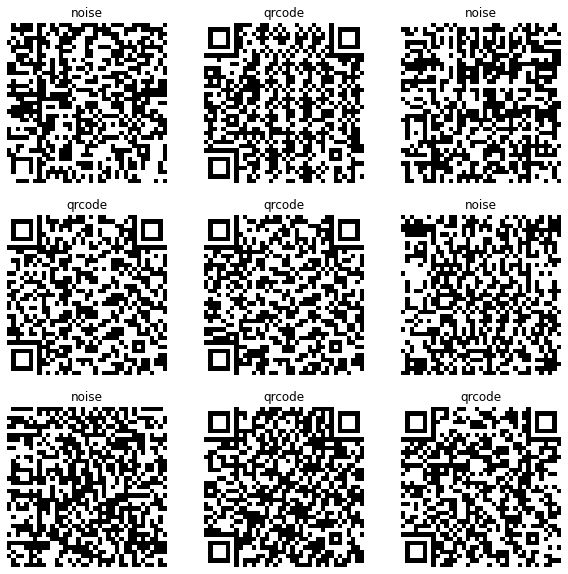

In [7]:
show_examples(train_ds)

In [8]:
# Prefetching the dataset for quicker execution.
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

### 3. Model Definition.
As said, the model is utterly simple:
* One convolution layer with a single filter size 3x3. No padding, it makes the size goes from 37x37 to 35x35
* AveragePooling to simplify the number of weights
* Flatten to connect to a dense layer
* Dense layer of 6 neurons only. It's enough!
* Last layer with one neuron, sigmoid function to discriminate between 0 and 1.

In [9]:
def CNN_lite(input_shape):
    '''Attempt to make the smallest CNN possible for this classification. 
    First inspirenet by the LeNet CNN, progressively simplified.'''
    
    model = keras.Sequential()
    
    model.add(layers.Conv2D(filters=1, kernel_size=(3, 3), activation='relu', 
                            input_shape=(input_shape[0], input_shape[1],1)))
    
    model.add(layers.AveragePooling2D())
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(units=8, activation='relu'))
        
    model.add(layers.Dense(units=1, activation = "sigmoid"))
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy", metrics=["accuracy"])
   
    return model

Let's plot the model and show it:

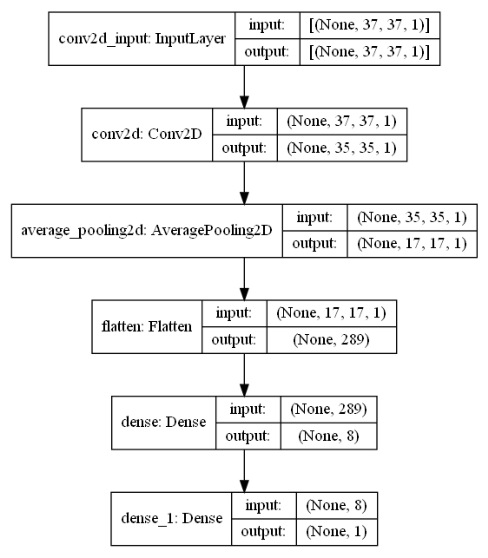

In [10]:
model = CNN_lite(input_shape=image_size)

keras.utils.plot_model(model, show_shapes=True, 
                       show_layer_names=True, expand_nested=True)

img_model = img.imread('model.png')

model_fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img_model)


### 4. Model training
5 epochs are enough, the task is quite easy. It regularly reaches >0.95 accuracy with only 5 epochs, 400 images in each class.

In [11]:
epochs = 5

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),]

model.fit(train_ds, epochs=epochs, 
          callbacks=callbacks, validation_data=val_ds)

Epoch 1/5
20/20 [==============================] - 1s 18ms/step - loss: 1.7623 - accuracy: 0.7141 - val_loss: 0.6864 - val_accuracy: 0.8562
Epoch 2/5
20/20 [==============================] - 0s 14ms/step - loss: 0.4079 - accuracy: 0.8813 - val_loss: 0.2844 - val_accuracy: 0.9062
Epoch 3/5
20/20 [==============================] - 0s 14ms/step - loss: 0.1743 - accuracy: 0.9406 - val_loss: 0.1681 - val_accuracy: 0.9375
Epoch 4/5
20/20 [==============================] - 0s 15ms/step - loss: 0.1029 - accuracy: 0.9688 - val_loss: 0.1132 - val_accuracy: 0.9688
Epoch 5/5
20/20 [==============================] - 0s 14ms/step - loss: 0.0700 - accuracy: 0.9859 - val_loss: 0.0998 - val_accuracy: 0.9750


### 5. Model dissection
Let's try it! What informations can we extract from the model?

In [12]:
# First, let's pick some random qrcodes: 

n_codes = 3
rng_list = random.sample(range(0, 100), n_codes)

random_imgs = []
for n in rng_list:
    img_link = dir_dataset + "/qrcodes/" + str(n) + ".png"
    random_imgs.append(img_link)


We use only a single convolution layer and a single 3x3 filter on this layer, so we can use a really simple method to check which part of the images were used to detect a qrcode. We will run a blanking square of 3*3 pixels on the images, and check the score of the model. When the score decreases, it means this part of the picture was "recognized" as a qrcode. We can then plot these predictions on the qrcode itself for better visualization.

In [13]:
def blank_img(img_link, model):
    '''This function will blank an image with a running square on all the surface of the image, and then 
    use the model to predict the score. This allows us to see what part of the image was the most important 
    for the prediction.'''
    
    img_to_load = keras.preprocessing.image.load_img(img_link, target_size=image_size, 
                                             color_mode="grayscale")
    
    # Shifting from Keras format to Numpy array.
    img_array = keras.preprocessing.image.img_to_array(img_to_load)
    to_blank = img_array.reshape(image_size)

    # Blanking block
    dimx, dimy = 3, 3
    blank = np.zeros((dimx,dimy))

    rows = to_blank.shape[0] // blank.shape[0]
    columns = to_blank.shape[1] // blank.shape[1]

    predictions = []
    for i in range(rows):
        for j in range(columns):
            
            array = np.array(to_blank).copy()
            
            # Progressively blanking the qrcode by dimx*dimy blocks.
            array[i*dimx:i*dimx+dimx, j*dimy:j*dimy+dimy] = blank
            
            # Back to Keras format for arrays: Observations * Dim1 * Dim2 * channels
            tf_array = array.reshape(1, to_blank.shape[0], to_blank.shape[1], 1)
            score = model.predict(tf_array)[0]
            
            # And append the new score to the predictions.
            predictions.append(score)

    # Simple reshaping and scaling of the score to get a 8-bits picture
    predictions = np.reshape(predictions, (rows, columns))
    pred_image = predictions - np.min(predictions)
    pred_image /= np.max(pred_image)
    pred_image *= 255
    
    return pred_image

Let's plot it now:

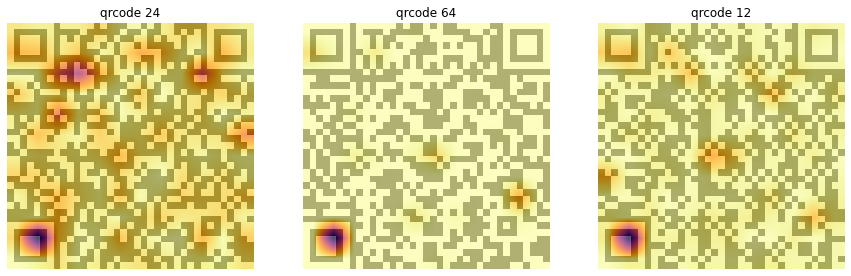

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 45))

# Extent is needed to match both pictures. Qrcode is 37*37 when the prediction 36*36.
# I could have padded it, but simpler this way.
extent = 0, 37, 0, 37
for i, link in enumerate(random_imgs):
        
    im = img.imread(link)  
    im1 = axs[i].imshow(im, cmap=plt.cm.gray, interpolation='nearest', extent=extent)
    
    predictions = blank_img(link, model)
    im2 = axs[i].imshow(predictions, cmap=plt.cm.inferno, alpha=.7, interpolation='bilinear',extent=extent)
    axs[i].axis('off')
    axs[i].set_title('qrcode ' + str(rng_list[i]))
    
plt.show() 
    

We can see it works: the "recognized" areas are in the squares, but not only. Some tries can be quite surprising, with area showed only outside of the squares. Now, we have to remember this method is not perfect at all: if a single filter (or serie of filters) recognizes multiple spot, blanking like I do will be inefficient. There will be other unblanked areas used to recognize the qrcode and the score will thus stay high.
A better way would be to remove multiple random parts of the image, remembering their index, and repeat this step multiple times. This way, we progressively build map of the prediction spots.

To finis this small exercise, we can show the convolution filters as well:

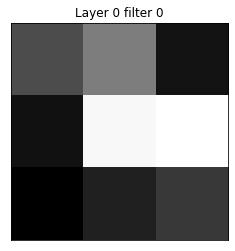

In [15]:
# First, make a list of all the convolution layers and get their filters weights.
conv_list = []
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
       
    # get filter weights, scale them
    filters, biases = layer.get_weights()
    fmin = filters.min()
    fmax = filters.max()
    filters = (filters - filters.min()) / (filters.max() - filters.min())
    filters *= 255
    
    conv_list.append(filters.astype(np.uint))
  
# And plot them
k=1
for i, conv in enumerate(conv_list):
    
    # get the filter
    f = conv[:, :, i, :]
    n_filters = f.shape[2]
    
    # plot each filter separately
    for j in range(n_filters):
        ax = plt.subplot(len(conv_list), n_filters, k)
        
        # specify subplot and turn off axis
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Layer ' + str(i) + ' filter ' + str(j))
        
        # plot filter channel in grayscale
        im = ax.imshow(f[:, :, j], cmap=plt.cm.gray, interpolation='nearest')
                
        k+=1
    
# show the figure
plt.show()

### Conclusion
This was a really simple example of convolution neural network applied to an easy situation. Some comments though:
* The aim was to obtain the simplest network, quick to train and explore. It worked nicely but...
* "Minimal CNN" means... brittle! With so few observations and epochs, it is possible from time to time to get 0.7 or 0.8 accuracy scores. And I would not recommend to decrease the number of neurons below 8.
* It is of course possible to get extremely good results by improving the CNN. A LeNet network with 4000 observations gets an accuracy of 1 everytime. However, being so good means my other tools like blanking are useless. The goal was to make a "borderless good" CNN to study the impact of different parameters.